## load result

In [1]:
import pickle
import time
from pprint import pprint as pp

def read_pickle_data(data_path):
    with open(data_path, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

path = "trg.pkl"
trg = pickle.load(open(path,"rb"))
path = "./predicts/codenn.pkl"
codenn = pickle.load(open(path,"rb"))
path = "./predicts/h_deepcom.pkl"
h_deepcom = pickle.load(open(path,"rb"))
path = "./predicts/att_gru.pkl"
attn_gru = pickle.load(open(path,"rb"))
path = "./predicts/ast_att_gru.pkl"
ast_att_gru = pickle.load(open(path,"rb"))
path = "./predicts/astnn.pkl"
astnn= pickle.load(open(path,"rb"))
path = "./predicts/code2seq.pkl"
code2seq= pickle.load(open(path,"rb"))
path = "./predicts/cocogum.pkl"
cocogum= pickle.load(open(path,"rb"))
# hybrid-drl
hybrid_DRL_res = pickle.load(open('./predicts/hybrid_drl.pkl','rb'))
result = hybrid_DRL_res
hybrid_DRL_fids = []
hybrid_DRL_preds = []
hybrid_DRL_tgts = []
for i in range(len(result)):
    hybrid_DRL_fids.append(result[i]['fid'])
    hybrid_DRL_preds.append(result[i]['pred'])
    hybrid_DRL_tgts.append(result[i]['tgt'])
trg_hybrid_drl = dict(zip( hybrid_DRL_fids,hybrid_DRL_tgts))
hybrid_DRL = dict(zip( hybrid_DRL_fids, hybrid_DRL_preds))

## Calculate diff len

In [2]:
import sys
sys.path.append("../")
from util.meteor.meteor import Meteor
from util.rouge.rouge import Rouge
from util.cider.cider import Cider
from util.CustomedBleu.smooth_bleu import smooth_bleu
import numpy as np

In [3]:
def compute_smooth_bleu(refs, preds):
   
    r_str_list = []
    p_str_list = []
    for r, p in zip(refs, preds):
        if len(r[0]) == 0 or len(p) == 0:
            continue

        r_str_list.append([" ".join([str(token_id) for token_id in r[0]])])
        p_str_list.append(" ".join([str(token_id) for token_id in p]))

    bleu_list = smooth_bleu(r_str_list, p_str_list)
        
    return bleu_list[0]

In [4]:
def calculate_four_metric(code_tokens, preds_in_paper, trgs_in_paper, test_fids_in_paper):
    st = time.perf_counter()
    refs_dict = {}
    preds_dict = {}
    for i in range(len(preds_in_paper)):
        preds_dict[i] = [" ".join(preds_in_paper[i])]
        refs_dict[i] = [" ".join(trgs_in_paper[i][0])]
    _, scores_Meteor_Trans = Meteor().compute_score(refs_dict, preds_dict)
    _, scores_Rouge_Trans = Rouge().compute_score(refs_dict, preds_dict)
    _, scores_Cider_Trans = Cider().compute_score(refs_dict, preds_dict)

    step_size = 1
    scores_Meteor_var_codelen = {}
    scores_Rouge_var_codelen = {}
    scores_Cider_var_codelen = {}
    scores_BLEU_var_codelen = {}
    # Bas_code_len ={}
    # codeBerts_code_len ={}
    count_code_len = {}

    for code_len in range(1, 250, step_size):
        scores_Meteor_var_codelen[code_len] = []
        scores_Rouge_var_codelen[code_len] = []
        scores_Cider_var_codelen[code_len] = []
        predict = []
        target = []
        count_code_len[code_len] = 0
        for num in range(len(test_fids_in_paper)):
            fid = test_fids_in_paper[num]
            if len(code_tokens["test"][fid]) == code_len:
                predict.append(preds_in_paper[num])
                target.append(trgs_in_paper[num])
                count_code_len[code_len] += 1
                scores_Meteor_var_codelen[code_len].append(scores_Meteor_Trans[num])
                scores_Rouge_var_codelen[code_len].append(scores_Rouge_Trans[num])
                scores_Cider_var_codelen[code_len].append(scores_Cider_Trans[num])
        if len(predict) == 0:
            continue
        scores_BLEU_var_codelen[code_len] = compute_smooth_bleu(target, predict)

    for i in scores_Meteor_var_codelen:
        scores_Meteor_var_codelen[i] = np.mean(scores_Meteor_var_codelen[i])
        scores_Rouge_var_codelen[i] = np.mean(scores_Rouge_var_codelen[i])
        scores_Cider_var_codelen[i] = np.mean(scores_Cider_var_codelen[i])
    print("time cost: ", time.perf_counter() - st)
    return count_code_len, scores_BLEU_var_codelen,  scores_Meteor_var_codelen, scores_Rouge_var_codelen,scores_Cider_var_codelen

In [5]:
def calculate_four_metric_diff_sum(sum_tokens, preds_in_paper, trgs_in_paper, test_fids_in_paper):
    st = time.perf_counter()
    refs_dict = {}
    preds_dict = {}
    for i in range(len(preds_in_paper)):
        preds_dict[i] = [" ".join(preds_in_paper[i])]
        refs_dict[i] = [" ".join(trgs_in_paper[i][0])]
    _, scores_Meteor_Trans = Meteor().compute_score(refs_dict, preds_dict)
    _, scores_Rouge_Trans = Rouge().compute_score(refs_dict, preds_dict)
    _, scores_Cider_Trans = Cider().compute_score(refs_dict, preds_dict)

    step_size = 1
    scores_Meteor_var_sumlen = {}
    scores_Rouge_var_sumlen = {}
    scores_Cider_var_sumlen = {}
    scores_BLEU_var_sumlen = {}
    # Bas_code_len ={}
    # codeBerts_code_len ={}
    count_sum_len = {}
    # for sum_len in range(30):
    for sum_len in range(1, 31, step_size):
        scores_Meteor_var_sumlen[sum_len] = []
        scores_Rouge_var_sumlen[sum_len] = []
        scores_Cider_var_sumlen[sum_len] = []
        predict = []
        target = []
        count_sum_len[sum_len] = 0
        for num in range(len(test_fids_in_paper)):
            fid = test_fids_in_paper[num]
            if len(sum_tokens["test"][fid]) == sum_len:
                predict.append(preds_in_paper[num])
                target.append(trgs_in_paper[num])
                count_sum_len[sum_len] += 1
                scores_Meteor_var_sumlen[sum_len].append(scores_Meteor_Trans[num])
                scores_Rouge_var_sumlen[sum_len].append(scores_Rouge_Trans[num])
                scores_Cider_var_sumlen[sum_len].append(scores_Cider_Trans[num])
        if len(predict) == 0:
            continue
        scores_BLEU_var_sumlen[sum_len] = compute_smooth_bleu(target, predict)

    for i in scores_Meteor_var_sumlen:
        scores_Meteor_var_sumlen[i] = np.mean(scores_Meteor_var_sumlen[i])
        scores_Rouge_var_sumlen[i] = np.mean(scores_Rouge_var_sumlen[i])
        scores_Cider_var_sumlen[i] = np.mean(scores_Cider_var_sumlen[i])
    print("time cost: ", time.perf_counter() - st)
    return count_sum_len, scores_BLEU_var_sumlen,  scores_Meteor_var_sumlen, scores_Rouge_var_sumlen,scores_Cider_var_sumlen

In [6]:
summary_tokens = {}
summary_tokens["test"] =  trg
code_tokens = pickle.load(open("code_tokens_test.pkl","rb"))

In [7]:
all_trg = {}
for fid in list(codenn.keys()):
    all_trg[fid] =  [summary_tokens["test"][fid][:11]]

#### codenn

In [8]:
codenn_trg = []
for fid in list(codenn.keys()):
    codenn_trg.append([summary_tokens["test"][fid][:11]])

In [9]:
import os
# codenn
if not os.path.exists('scores_codenn_code.pkl'):
    data = calculate_four_metric(code_tokens,list(codenn.values()),codenn_trg, list(codenn.keys()))
    pickle.dump(data, open('scores_codenn_code.pkl', 'wb'))
    
if not os.path.exists('scores_codenn_sum.pkl'):
    data = calculate_four_metric_diff_sum(summary_tokens,list(codenn.values()),codenn_trg, list(codenn.keys()))
    pickle.dump(data, open('scores_codenn_sum.pkl', 'wb'))
    
(count_code_len, 
 scores_BLEU_codenn_var_codelen,
 scores_Meteor_codenn_var_codelen, 
 scores_Rouge_codenn_var_codelen, 
 scores_Cider_codenn_var_codelen) = pickle.load(open('scores_codenn_code.pkl', 'rb'))
(count_sum_len, 
 scores_BLEU_codenn_var_sumlen, 
 scores_Meteor_codenn_var_sumlen, 
 scores_Rouge_codenn_var_sumlen, 
 scores_Cider_codenn_var_sumlen) = pickle.load(open('scores_codenn_sum.pkl', 'rb'))

#### h-deepcom

In [10]:
if not os.path.exists('scores_hdeepcom_code.pkl'):
    data = calculate_four_metric(code_tokens,list(h_deepcom.values()),codenn_trg, list(h_deepcom.keys()))
    pickle.dump(data, open('scores_hdeepcom_code.pkl', 'wb'))
if not os.path.exists('scores_hdeepcom_sum.pkl'):
    data = calculate_four_metric_diff_sum(summary_tokens,list(h_deepcom.values()),codenn_trg, list(h_deepcom.keys()))
    pickle.dump(data, open('scores_hdeepcom_sum.pkl', 'wb'))

(count_code_len_h_deepcom, 
 scores_BLEU_deepcom_var_codelen, 
 scores_Meteor_deepcom_var_codelen, 
 scores_Rouge_deepcom_var_codelen,
 scores_Cider_deepcom_var_codelen) = pickle.load(open('scores_hdeepcom_code.pkl', 'rb'))
(count_sum_len_h_deeocom, 
 scores_BLEU_deepcom_var_sumlen,
 scores_Meteor_deepcom_var_sumlen,
 scores_Rouge_deepcom_var_sumlen,
 scores_Cider_deepcom_var_sumlen) = pickle.load(open('scores_hdeepcom_sum.pkl', 'rb'))

####  ast-att-gru

In [11]:
if not os.path.exists('scores_astattgru_code.pkl'):
    data = calculate_four_metric(code_tokens,list(ast_att_gru.values()),codenn_trg, list(ast_att_gru.keys()))
    pickle.dump(data, open('scores_astattgru_code.pkl', 'wb'))
if not os.path.exists('scores_astattgru_sum.pkl'):
    data = calculate_four_metric_diff_sum(summary_tokens ,list(ast_att_gru.values()),codenn_trg, list(ast_att_gru.keys()))
    pickle.dump(data, open('scores_astattgru_sum.pkl', 'wb'))
    
(count_code_len_ast_att_gru, 
 scores_BLEU_ast_attendgru_var_codelen,
 scores_Meteor_ast_attendgru_var_codelen, 
 scores_Rouge_ast_attendgru_var_codelen,
 scores_Cider_ast_attendgru_var_codelen) = pickle.load(open('scores_astattgru_code.pkl', 'rb'))
(count_sum_len_ast_att_gru, 
 scores_BLEU_ast_att_gru_var_sumlen,
 scores_Meteor_ast_att_gru_var_sumlen, 
 scores_Rouge_ast_att_gru_var_sumlen,
 scores_Cider_ast_att_gru_var_sumlen) = pickle.load(open('scores_astattgru_sum.pkl', 'rb'))

#### hybrid-DRL

In [12]:
if not os.path.exists('scores_hybriddrl_code.pkl'):
    data = calculate_four_metric(code_tokens,hybrid_DRL_preds,hybrid_DRL_tgts, hybrid_DRL_fids)
    pickle.dump(data, open('scores_hybriddrl_code.pkl', 'wb'))
if not os.path.exists('scores_hybriddrl_sum.pkl'):
    data = calculate_four_metric_diff_sum(summary_tokens ,hybrid_DRL_preds,hybrid_DRL_tgts, hybrid_DRL_fids)
    pickle.dump(data, open('scores_hybriddrl_sum.pkl', 'wb'))

(count_code_len_hybrid_DRL, 
 scores_BLEU_hybrid_DRL_var_codelen,
 scores_Meteor_hybrid_DRL_var_codelen, 
 scores_Rouge_hybrid_DRL_var_codelen,
 scores_Cider_hybrid_DRL_var_codelen) = pickle.load(open('scores_hybriddrl_code.pkl', 'rb'))
(count_sum_len_hybrid_DRL, 
 scores_BLEU_hybrid_DRL_var_sumlen,
 scores_Meteor_hybrid_DRL_var_sumlen, 
 scores_Rouge_hybrid_DRL_var_sumlen,
 scores_Cider_hybrid_DRL_var_sumlen) = pickle.load(open('scores_hybriddrl_sum.pkl', 'rb'))

#### astnn

In [13]:
astnn_trg = []
for fid in list(astnn.keys()):
    astnn_trg.append([summary_tokens["test"][fid][:11]])

In [14]:
if not os.path.exists('scores_astnn_code.pkl'):
    data = calculate_four_metric(code_tokens,list(astnn.values()),astnn_trg, list(astnn.keys()))
    pickle.dump(data, open('scores_astnn_code.pkl', 'wb'))
if not os.path.exists('scores_astnn_sum.pkl'):
    data = calculate_four_metric_diff_sum(summary_tokens,list(astnn.values()),astnn_trg, list(astnn.keys()))
    pickle.dump(data, open('scores_astnn_sum.pkl', 'wb'))    

(count_code_len_astnn,
 scores_BLEU_astnn_var_codelen,
 scores_Meteor_astnn_var_codelen,
 scores_Rouge_astnn_var_codelen,
 scores_Cider_astnn_var_codelen) = pickle.load(open('scores_astnn_code.pkl', 'rb'))
(count_sum_len_astnn,
 scores_BLEU_astnn_var_sumlen,
 scores_Meteor_astnn_var_sumlen, 
 scores_Rouge_astnn_var_sumlen,
 scores_Cider_astnn_var_sumlen) = pickle.load(open('scores_astnn_sum.pkl', 'rb'))

#### code2seq

In [15]:
code2seq_trg = []
for fid in list(code2seq.keys()):
    code2seq_trg.append([summary_tokens["test"][fid][:11]])

In [16]:
if not os.path.exists('scores_code2seq_code.pkl'):
    data = calculate_four_metric(code_tokens,list(code2seq.values()),code2seq_trg, list(code2seq.keys()))
    pickle.dump(data, open('scores_code2seq_code.pkl', 'wb'))
if not os.path.exists('scores_code2seq_sum.pkl'):
    data = calculate_four_metric_diff_sum(summary_tokens,list(code2seq.values()),code2seq_trg, list(code2seq.keys()))
    pickle.dump(data, open('scores_code2seq_sum.pkl', 'wb'))    
    
(count_code_len_code2seq, 
 scores_BLEU_code2seq_var_codelen,
 scores_Meteor_code2seq_var_codelen, 
 scores_Rouge_code2seq_var_codelen,
 scores_Cider_code2seq_var_codelen) = pickle.load(open('scores_code2seq_code.pkl', 'rb'))
(count_sum_len_code2seq, 
 scores_BLEU_code2seq_var_sumlen,
 scores_Meteor_code2seq_var_sumlen, 
 scores_Rouge_code2seq_var_sumlen,
 scores_Cider_code2seq_var_sumlen) = pickle.load(open('scores_code2seq_sum.pkl', 'rb'))

#### CoCoGUm

In [29]:
if not os.path.exists('scores_cocogum_code.pkl'):
    data = calculate_four_metric(code_tokens,cocogum[" preds"],cocogum["trgs"], cocogum["test_fids"])
    pickle.dump(data, open('scores_cocogum_code.pkl', 'wb'))
if not os.path.exists('scores_cocogum_sum.pkl'):
    data = calculate_four_metric_diff_sum(summary_tokens,cocogum[" preds"],cocogum["trgs"], cocogum["test_fids"])
    pickle.dump(data, open('scores_cocogum_sum.pkl', 'wb'))

(count_code_len_cocogum_best, 
 scores_BLEU_cocogum_best_var_codelen,
 scores_Meteor_cocogum_best_var_codelen, 
 scores_Rouge_cocogum_best_var_codelen,
 scores_Cider_cocogum_best_var_codelen) = pickle.load(open('scores_cocogum_code.pkl', 'rb'))
(count_sum_len_cocogum_best, 
 scores_BLEU_cocogum_best_var_sumlen,
 scores_Meteor_cocogum_best_var_sumlen, 
 scores_Rouge_cocogum_best_var_sumlen,
 scores_Cider_cocogum_best_var_sumlen) = pickle.load(open('scores_cocogum_sum.pkl', 'rb'))

### plot diff len

In [64]:
import matplotlib.pyplot as plt
# codeuml_lable = 'CoCoGUM'
# bert_lable = r'$\rm{CoCoGUM_m}$'
ast_attendgru_label = 'Ast-attendgru'
h_deppcom_lable= 'H-Deepcom'
codenn_lable = 'Code-NN'
hybrid_DRL_lable = "hybrid-DRL"
astnn_lable = "astnn"
rencos_lable = "rencos"
code2seq_lable = "code2seq"
cocogum_label = "CoCoGUM"
plt.rc('text', usetex = False)
os.makedirs('Figure', exist_ok=True)

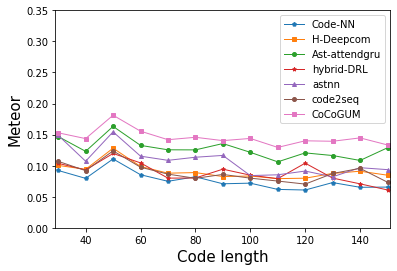

<Figure size 432x288 with 0 Axes>

In [73]:
def plot_bleu(data,xlabel,ylabel,step,filename,xmin=0,xmax=151, ymin=0, ymax=0.35):
    n = len(data)
    plotdata = [{} for i in range(n)]
    for i in data[0]:
        if i %step ==0 and i<xmax:
            for p in range(n):
                plotdata[p][i] = data[p][i]

    ax = plt.subplot(111)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    markers = ['p','s','o','*','^','o','s']
    labels = [codenn_lable,h_deppcom_lable,ast_attendgru_label,hybrid_DRL_lable,astnn_lable,code2seq_lable,cocogum_label]
    for p in range(n):
        ax.plot(plotdata[p].keys(),plotdata[p].values(),marker=markers[p],linewidth=1,markersize=4,label=labels[p])
    ax.legend(fontsize='10', ncol=1, loc='upper right')
    plt.xlim(xmin=xmin, xmax=xmax)
    plt.ylim(ymin=ymin, ymax=ymax)
    # plt.xticks(list(plotdata[0].keys()), fontsize='10')
    # plt.yticks(fontsize='10')
    plt.show()
    plt.figure().savefig(filename)

    
plot_bleu([scores_Meteor_codenn_var_codelen,
              scores_Meteor_deepcom_var_codelen,
              scores_Meteor_ast_attendgru_var_codelen,
              scores_Meteor_hybrid_DRL_var_codelen,
              scores_Meteor_astnn_var_codelen,
              scores_Meteor_code2seq_var_codelen,
              scores_Meteor_cocogum_best_var_codelen],
              "Code length","Meteor",step, './Figure/varcode_Meteor_{}.pdf'.format(step),
          xmin=29, xmax=151, ymin=0.0, ymax=0.35)

In [30]:
# data = calculate_four_metric(code_tokens,list(codenn.values()),codenn_trg, list(codenn.keys()))
# scores_Meteor_codenn_var_codelen = data[2]
# step = 10
# print(scores_Meteor_codenn_var_codelen)

In [31]:
print(type(code_tokens))
print(code_tokens.keys())
print(type(code_tokens['test']))
print(len(code_tokens['test']))
# print(code_tokens['test'].keys())
print(code_tokens['test'][469779])

<class 'dict'>
dict_keys(['test'])
<class 'dict'>
26909
['protected', 'final', 'void', 'fast', 'path', 'ordered', 'emit', '(', 'u', 'value', ',', 'boolean', 'delay', 'error', ',', 'disposable', 'disposable', ')', '{', 'final', 'observer', '<', '?', 'super', 'v', '>', 'observer', '=', 'downstream', ';', 'final', 'simple', 'plain', 'queue', '<', 'u', '>', 'q', '=', 'queue', ';', 'if', '(', 'wip', 'get', '(', ')', '==', '<num>', '&&', 'wip', 'compare', 'and', 'set', '(', '<num>', ',', '<num>', ')', ')', '{', 'if', '(', 'q', 'is', 'empty', '(', ')', ')', '{', 'accept', '(', 'observer', ',', 'value', ')', ';', 'if', '(', 'leave', '(', '-', '<num>', ')', '==', '<num>', ')', '{', 'return', ';', '}', '}', 'else', '{', 'q', 'offer', '(', 'value', ')', ';', '}', '}', 'else', '{', 'q', 'offer', '(', 'value', ')', ';', 'if', '(', '!', 'enter', '(', ')', ')', '{', 'return', ';', '}', '}', 'queue', 'drain', 'helper', 'drain', 'loop', '(', 'q', ',', 'observer', ',', 'delay', 'error', ',', 'disposable

In [22]:
print(type(codenn))
# print(codenn.keys())
print(len(codenn))
print(codenn[469779])
print(type(codenn_trg))
print(len(codenn_trg))
print(codenn_trg[0])

<class 'dict'>
17152
['returns', 'the', 'the', 'the', 'the']
<class 'list'>
17152
[['makes', 'sure', 'the', 'fast', 'path', 'emits', 'in', 'order']]


[30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
range(30, 151, 10)


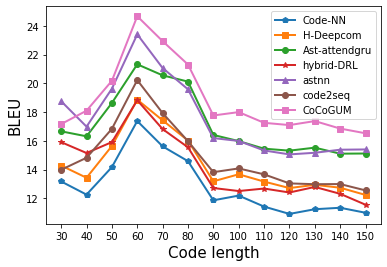

In [24]:
# plot by range.
def plot_bleu_range(data, # [s1_data, ..., s8_data]
                    xlabel,
                    ylabel,
                    splits,
                    maxsize,
                    file):
    n = len(data)
    plotdata = [{} for i in range(n)]
    
    print(splits)
    
    step = splits[1] - splits[0]
    k = 0
    j = splits[k]
    for i in range(n):
        plotdata[i][j] = 0
    
    for i in data[0]:
        if i < maxsize:
            if i > j:
                k += 1
                j = splits[k]
                for p in range(n):
                    plotdata[p][j] = 0
            for p in range(n):
                plotdata[p][j] += data[p][i]
    
    for p in range(n):
        for j in plotdata[p]:
            plotdata[p][j] /= step
        
    fontsize = 15
    linewidth = 2.0
    markersize = 6
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    markers = ['p','s','o','*','^','o','s']
    labels = [  codenn_lable,
                h_deppcom_lable,
                ast_attendgru_label,
                hybrid_DRL_lable,
                astnn_lable,
                code2seq_lable,
                sliced_ast_RvNNCodeAttGRU_lable ]
    
    for p in range(n):
        ax.plot(list(plotdata[p].keys()), 
                list(plotdata[p].values()), 
                marker=markers[p],
                linewidth=linewidth, 
                markersize=markersize, 
                label=labels[p]
               )
    
    ax.legend(fontsize='10',ncol=1) #, loc='upper center'
    my_x_ticks =list(plotdata[6].keys())
    plt.xticks(my_x_ticks,fontsize='10')
    plt.yticks(fontsize='10')
    plt.show()
    fig.savefig(file)
    
splits = range(30, 151, 10)
print(list(splits))
data = [scores_BLEU_codenn_var_codelen,
          scores_BLEU_deepcom_var_codelen,
          scores_BLEU_ast_attendgru_var_codelen,
          scores_BLEU_hybrid_DRL_var_codelen,
          scores_BLEU_astnn_var_codelen,
          scores_BLEU_code2seq_var_codelen,
          scores_BLEU_cocogum_best_var_codelen]
step = splits[1] - splits[0]
plot_bleu_range(data, "Code length","BLEU",splits,151,'./Figure/varcode_bleu_{}.pdf'.format(step))

#### code

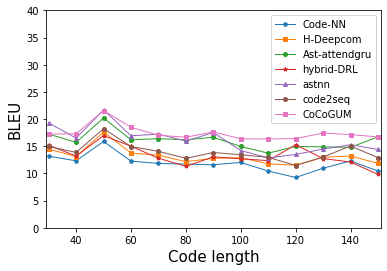

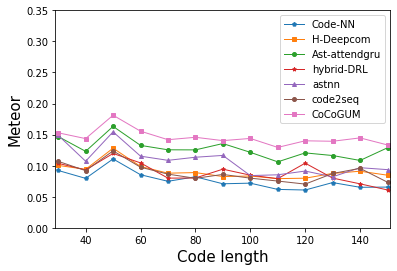

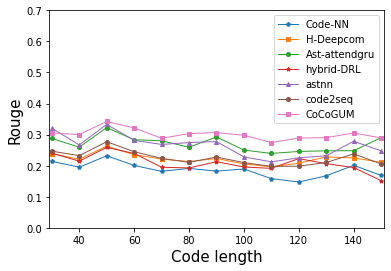

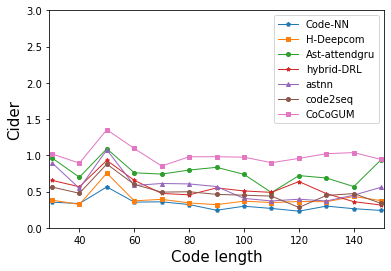

<Figure size 432x288 with 0 Axes>

In [81]:
def plot_code_diff(step=10):
    plot_bleu([scores_BLEU_codenn_var_codelen,
              scores_BLEU_deepcom_var_codelen,
              scores_BLEU_ast_attendgru_var_codelen,
              scores_BLEU_hybrid_DRL_var_codelen,
              scores_BLEU_astnn_var_codelen,
              scores_BLEU_code2seq_var_codelen,
              scores_BLEU_cocogum_best_var_codelen],
              "Code length","BLEU",step,'./Figure/varcode_bleu_{}.pdf'.format(step),
              xmin=29, xmax=151, ymin=0, ymax=40)
    plot_bleu([scores_Meteor_codenn_var_codelen,
              scores_Meteor_deepcom_var_codelen,
              scores_Meteor_ast_attendgru_var_codelen,
              scores_Meteor_hybrid_DRL_var_codelen,
              scores_Meteor_astnn_var_codelen,
              scores_Meteor_code2seq_var_codelen,
              scores_Meteor_cocogum_best_var_codelen],
              "Code length","Meteor",step,'./Figure/varcode_Meteor_{}.pdf'.format(step),
              xmin=29, xmax=151, ymin=0, ymax=0.35)
    plot_bleu([scores_Rouge_codenn_var_codelen,
              scores_Rouge_deepcom_var_codelen,
              scores_Rouge_ast_attendgru_var_codelen,
              scores_Rouge_hybrid_DRL_var_codelen,
              scores_Rouge_astnn_var_codelen,
              scores_Rouge_code2seq_var_codelen,
              scores_Rouge_cocogum_best_var_codelen],
              "Code length","Rouge",step,'./Figure/varcode_Rouge_{}.pdf'.format(step),
              xmin=29, xmax=151, ymin=0, ymax=0.7)
    plot_bleu([scores_Cider_codenn_var_codelen,
              scores_Cider_deepcom_var_codelen,
              scores_Cider_ast_attendgru_var_codelen,
              scores_Cider_hybrid_DRL_var_codelen,
              scores_Cider_astnn_var_codelen,
              scores_Cider_code2seq_var_codelen,
               scores_Cider_cocogum_best_var_codelen],
              "Code length","Cider",step,'./Figure/varcode_Cider_{}.pdf'.format(step),
              xmin=29, xmax=151, ymin=0, ymax=3)

plot_code_diff(step=10)

#### summary

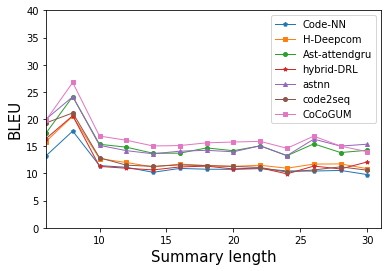

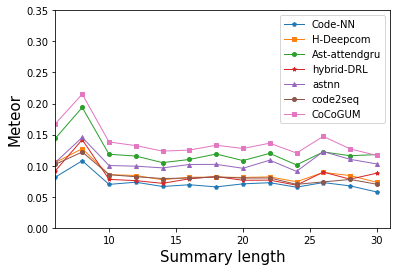

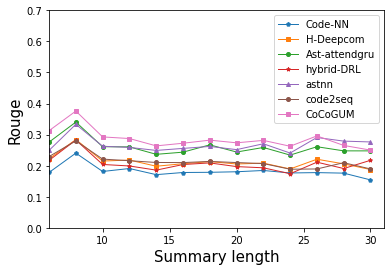

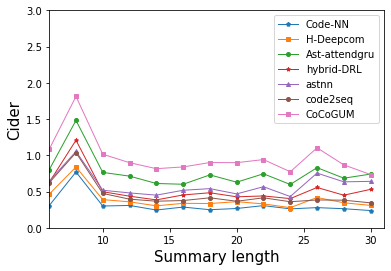

<Figure size 432x288 with 0 Axes>

In [98]:
def plot_sum_diff(step=2):
    plot_bleu([scores_BLEU_codenn_var_sumlen,
              scores_BLEU_deepcom_var_sumlen,
              scores_BLEU_ast_att_gru_var_sumlen,
              scores_BLEU_hybrid_DRL_var_sumlen,
              scores_BLEU_astnn_var_sumlen,
              scores_BLEU_code2seq_var_sumlen,
              scores_BLEU_cocogum_best_var_sumlen],
              "Summary length","BLEU",step, './Figure/varsum_bleu_{}.pdf'.format(step),
              xmin=6, xmax=31, ymin=0, ymax=40)
    plot_bleu([scores_Meteor_codenn_var_sumlen,
               scores_Meteor_deepcom_var_sumlen,
               scores_Meteor_ast_att_gru_var_sumlen,
               scores_Meteor_hybrid_DRL_var_sumlen,
               scores_Meteor_astnn_var_sumlen,
               scores_Meteor_code2seq_var_sumlen,
               scores_Meteor_cocogum_best_var_sumlen],
               "Summary length","Meteor",step, './Figure/varsum_Meteor_{}.pdf'.format(step),
              xmin=6, xmax=31, ymin=0, ymax=0.35)
    plot_bleu([scores_Rouge_codenn_var_sumlen,
               scores_Rouge_deepcom_var_sumlen,
               scores_Rouge_ast_att_gru_var_sumlen,
               scores_Rouge_hybrid_DRL_var_sumlen,
               scores_Rouge_astnn_var_sumlen,
               scores_Rouge_code2seq_var_sumlen,
               scores_Rouge_cocogum_best_var_sumlen],
               "Summary length","Rouge",step, './Figure/varsum_Rouge_{}.pdf'.format(step),
              xmin=6, xmax=31, ymin=0, ymax=0.7)
    plot_bleu([scores_Cider_codenn_var_sumlen,
               scores_Cider_deepcom_var_sumlen,
               scores_Cider_ast_att_gru_var_sumlen,
               scores_Cider_hybrid_DRL_var_sumlen,
               scores_Cider_astnn_var_sumlen,
               scores_Cider_code2seq_var_sumlen,
               scores_Cider_cocogum_best_var_sumlen],
               "Summary length","Cider",step, './Figure/varsum_Cider_{}.pdf'.format(step),
              xmin=6, xmax=31, ymin=0, ymax=3)

plot_sum_diff(step=2)

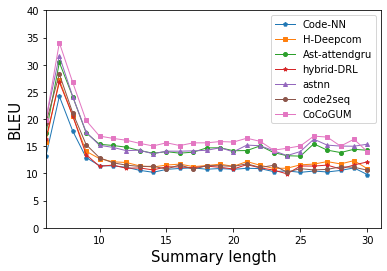

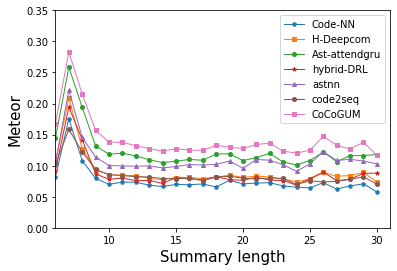

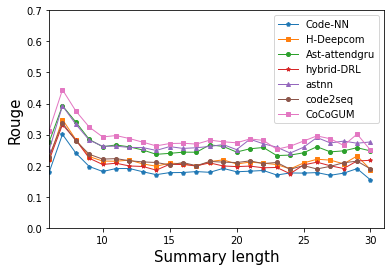

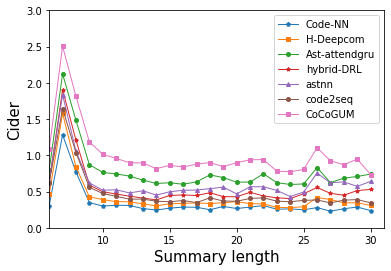

<Figure size 432x288 with 0 Axes>

In [94]:
plot_sum_diff(step=1)

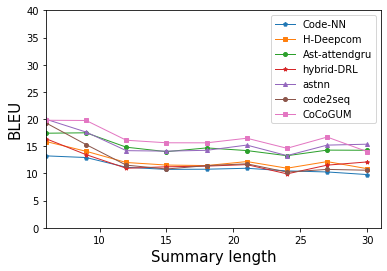

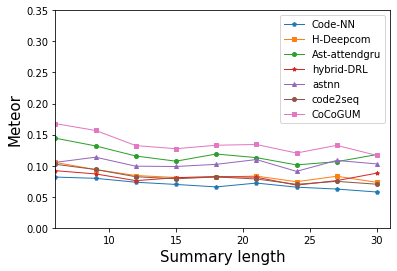

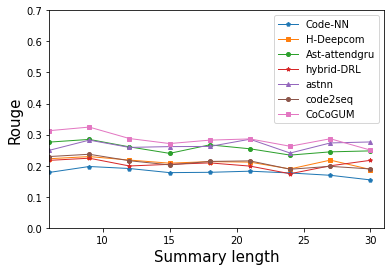

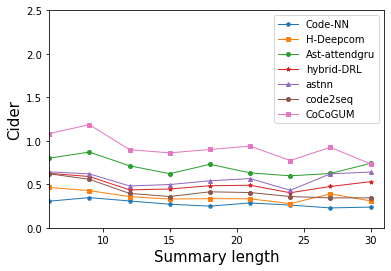

<Figure size 432x288 with 0 Axes>

In [97]:
plot_sum_diff(step=3)